In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Sistema de predicción de ventas

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

# Paso 1: Carga del conjunto de datos

El conjunto de datos se puede encontrar en esta carpeta de proyecto bajo el nombre sales.csv. Puedes cargarlos en el código directamente desde el siguiente enlace:

In [75]:
df = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv")
df.head(20)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


# Paso 2: Construye y analiza la serie temporal

Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

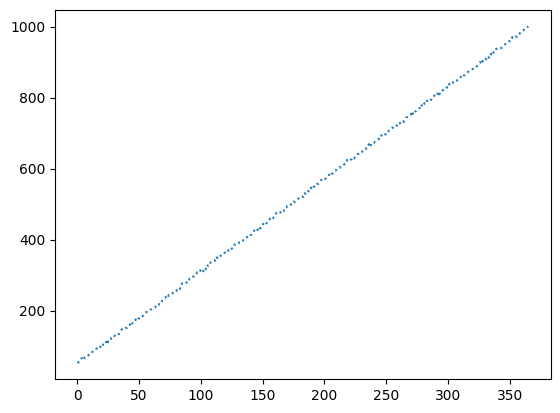

In [76]:
# visualisacion de las ventas reales por dia
ypoints = df["sales"]

plt.plot(ypoints, linestyle = 'dotted')
plt.show()

se observa que las ventas tienen una tendencia a crecer linealmente conforme al paso de los dias.

## limpieza de los datos

primero convertimos nuestra columna dates a formato solo de fecha

In [77]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [78]:
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [79]:
# convertir el date en el indice del dataframe
df = df.set_index('date')

In [80]:
# dejar el indice solo con la fecha eliminando las horas
df.index = df.index.normalize()

In [81]:
df.head(5)

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


En este caso, la dimensión temporal estará compuesta por el año mes y dia(date) y el dato que observaremos a lo largo del tiempo será el número de ventas (sales).

In [82]:
ts = df["sales"]

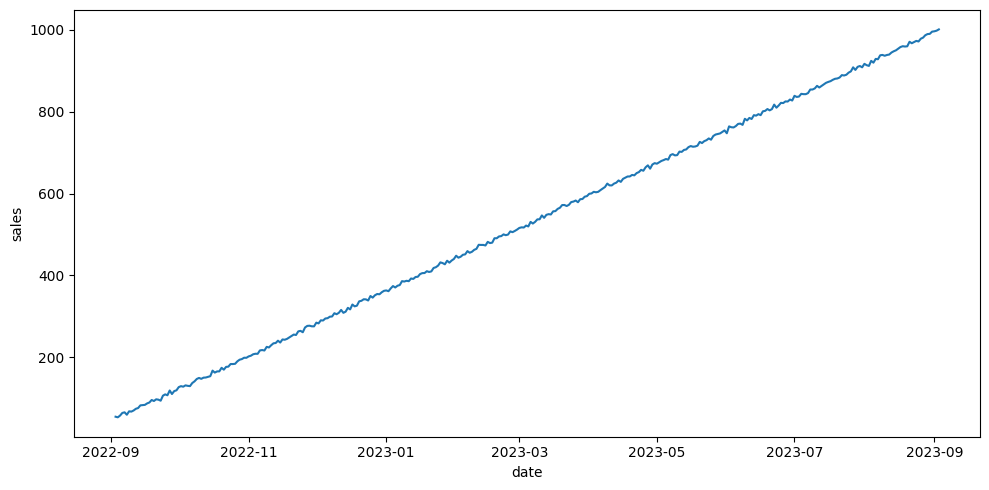

In [83]:
#analizando los datos con el indice fecha

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
plt.tight_layout()
plt.show()

Paso 2. Análisis de una serie temporal
Para analizar una serie temporal, como vimos en la teoría, debemos estudiar varios parámetros:

Tendencia: Se aprecia una tendencia ascendente, lo que indica que el número de ventas ha aumentado a lo largo del tiempo.

Estacionalidad: no se observa una  estacionalidad marcada.. solo se logra observar una inclinacion siempre ascendente.

Variabilidad: Se observan muy pocos puntos de variabilidad en donde las ventas bajan un poco en comparacion con el dia  anterior y luego sigue su comportamiento ascendiente

Puntos de inflexión: Dependiendo del año, el aumento en el número de pasajeros no es regular y a veces se producen variaciones en la pendiente; estos son, puntos de inflexión.
A través de un análisis visual podríamos ser capaces de estimar estas métricas a ojo, pero siempre es mejor orientar el análisis a los datos matemáticos. Para la labor de realizar predicciones sobre series temporales y analizarlas, nos apoyaremos en la librería statsmodels:

Descomposición de la serie
La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

## Asegurar que la frecuencia temporal sea diaria

ARIMA necesita una frecuencia constante. Si faltan fechas, deben completarse.

In [84]:

ts = ts.asfreq('D')
ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Freq: D, Name: sales, Length: 366, dtype: float64

aqui podemos observar que nuestros  datos comienzan con fecha en 3 de septiembre de 2022 y terminan un 03 de septiempre de 2023 y tenemos una longitud de 366 datos, lo que nos indica que no hacen falta datos, en caso de datos faltantes tendriamos que buscar la manera de rellenar esos datos

## Descomposición de la serie

La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

In [86]:
decomposition = seasonal_decompose(ts, period = 1)
decomposition

## Análisis de la tendencia

La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos al componente trend del resultado decomposition.

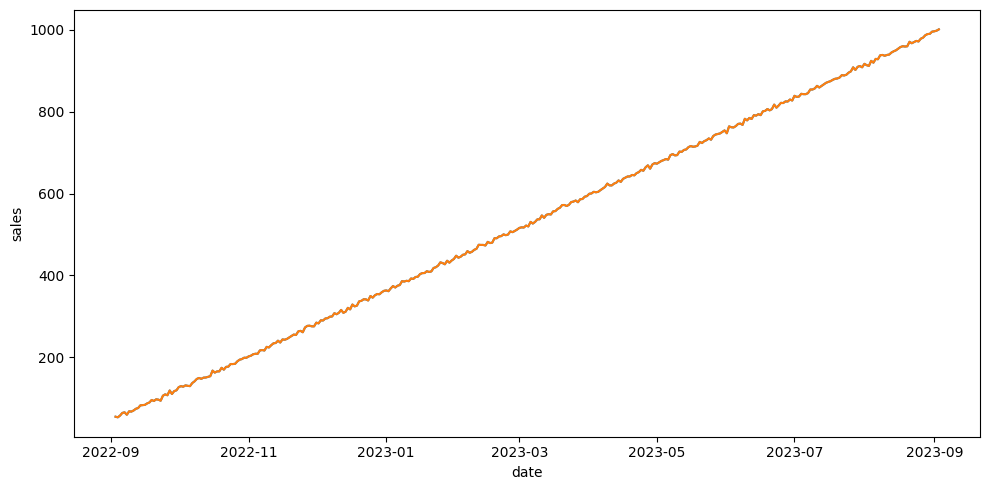

In [ ]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Se confirma lo observado: una clara tendencia positiva a lo largo de los dias

## Análisis de la estacionalidad

La estacionalidad se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos al componente seasonal del resultado decomposition.

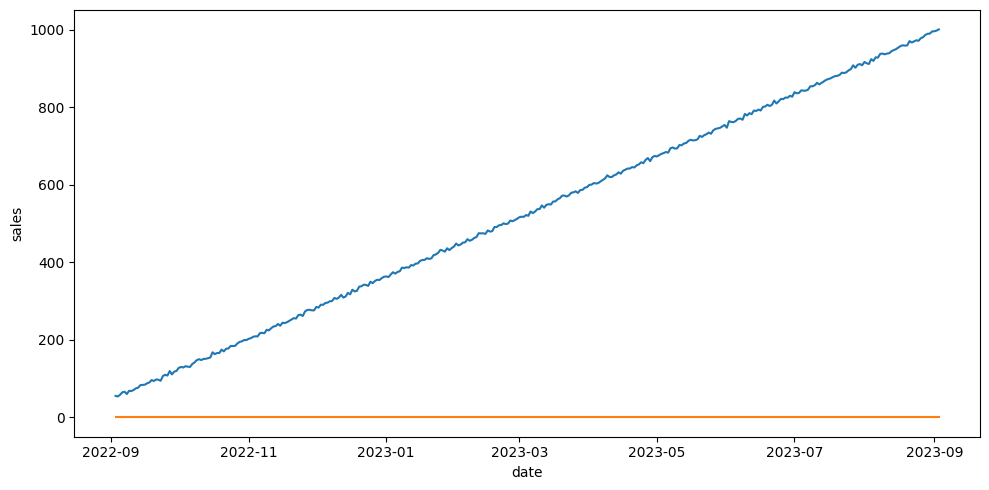

In [87]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie no es estacionaria, y la alternativa, que es estacionaria:

In [89]:

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula no se puede rechazar y tomaremos esta serie como no  estacionaria.